<a href="https://colab.research.google.com/github/tofighi/ADNI/blob/master/sample4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import cv2
import numpy as np
import argparse
import imutils
import time
import cv2
import os
from matplotlib import pyplot as plt


args = {}
args["start_frame"] = 1
args["end_frame"] = 2
args["yolo"] = "yolo-coco"
args["confidence"] = 0.01
args["threshold"] = 0.01
args["input"] = "obstacle.mp4"
args["input_depth"] = "obstacle_depth.mp4"
args["output"] = "obstacle_out.mp4"
args["output_depth"] = "obstacle_depth_out.mp4"
args["obstacles"] = ["car"]

In [ ]:
!wget -q https://sinamedialab.com/repository/documents/alfred/obstacle.mp4 -O obstacle.mp4
!wget -q https://sinamedialab.com/repository/documents/alfred/obstacle_depth.mp4 -O obstacle_depth.mp4

# Download object detection models

In [ ]:
!mkdir yolo-coco 
!wget -q https://sinamedialab.com/repository/documents/alfred/yolo-coco/coco.names -O /content/yolo-coco/coco.names
!wget -q https://sinamedialab.com/repository/documents/alfred/yolo-coco/yolov3.weights -O /content/yolo-coco/yolov3.weights
!wget -q https://sinamedialab.com/repository/documents/alfred/yolo-coco/yolov3.cfg -O /content/yolo-coco/yolov3.cfg

# Object Detection

[INFO] loading YOLO from disk...
[INFO] 25 total frames in video
[INFO] single frame took 2.0099 seconds
[INFO] estimated total time to finish: 50.2482


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:273: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:275: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[INFO] cleaning up...


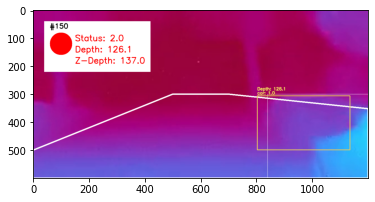

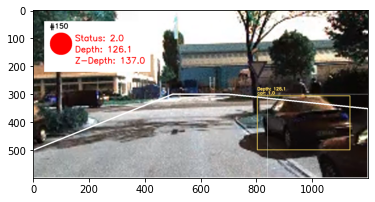

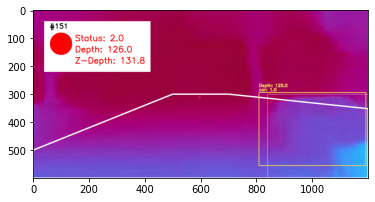

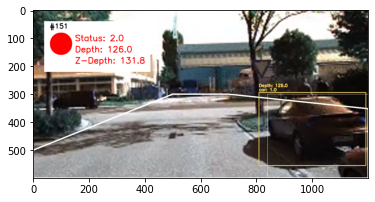

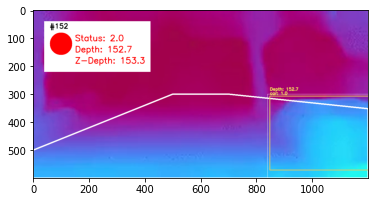

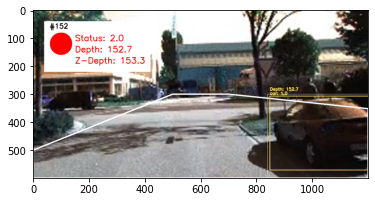

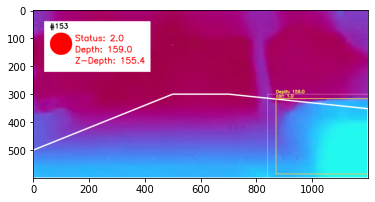

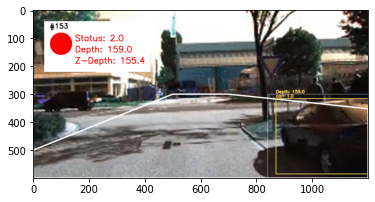

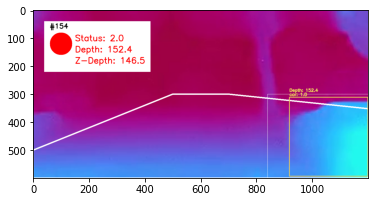

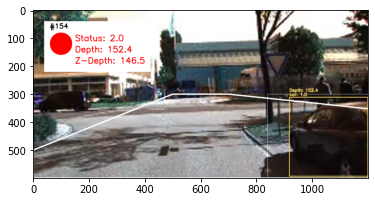

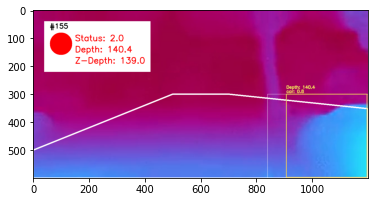

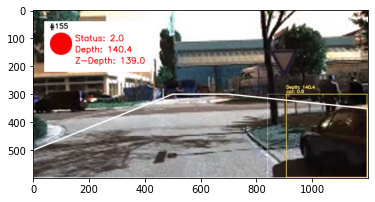

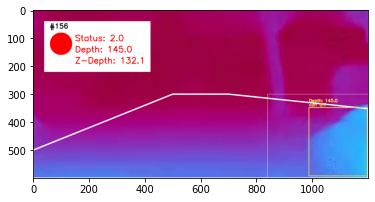

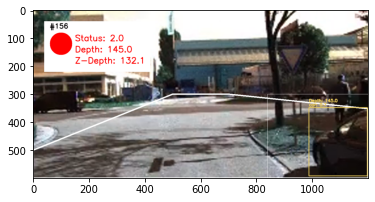

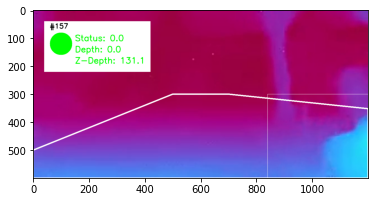

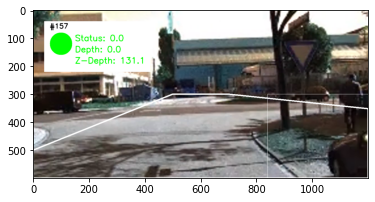

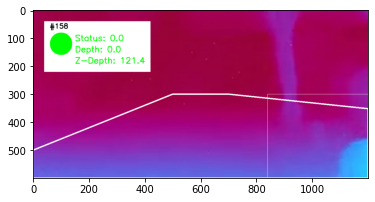

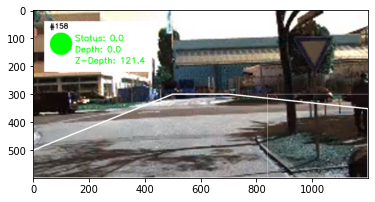

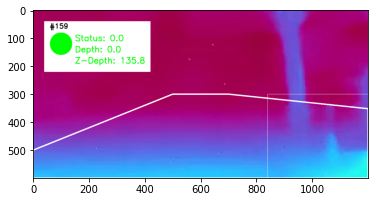

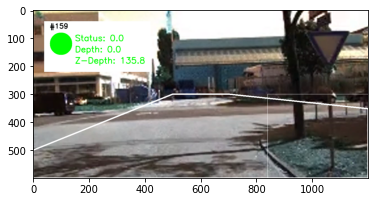

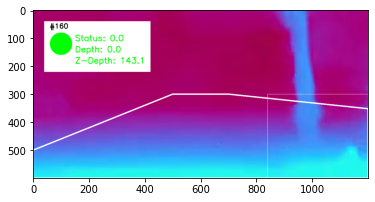

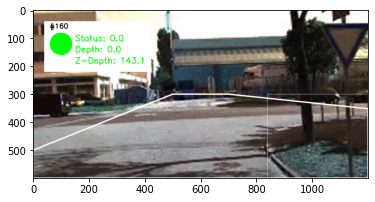

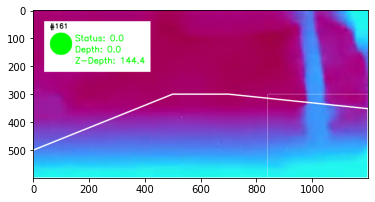

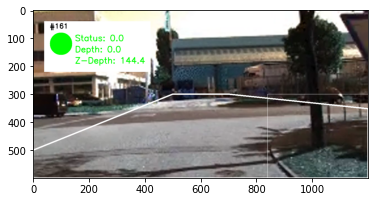

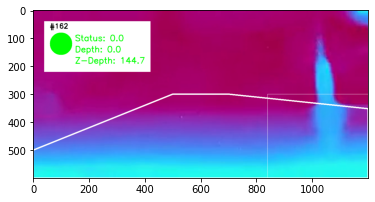

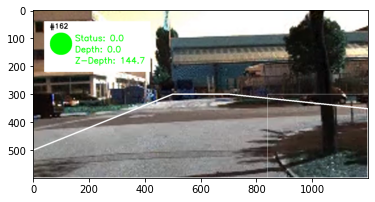

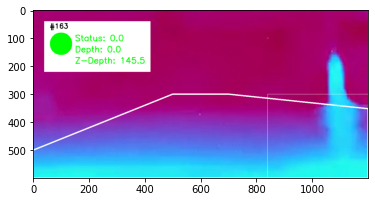

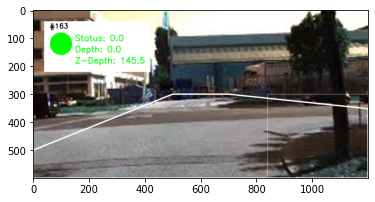

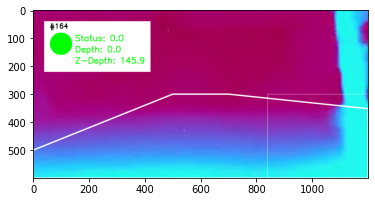

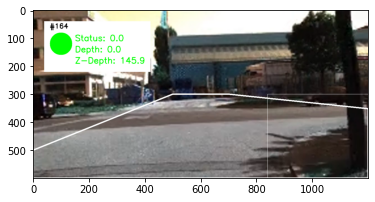

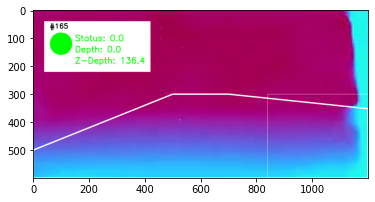

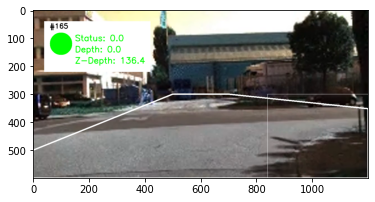

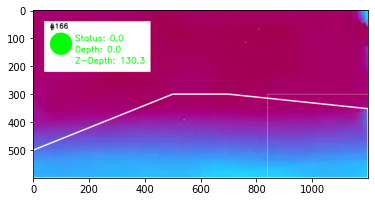

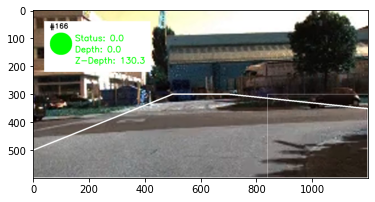

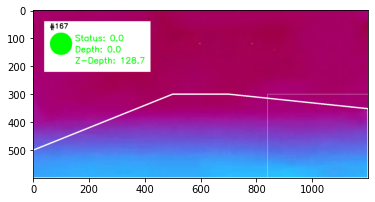

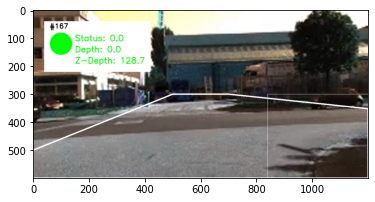

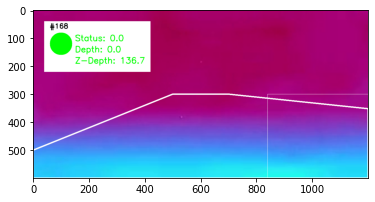

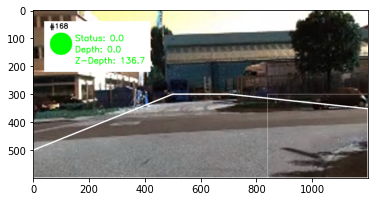

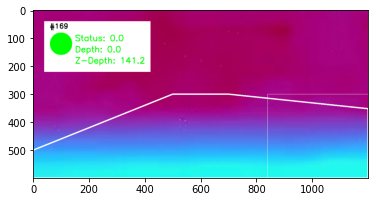

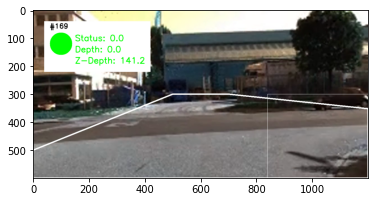

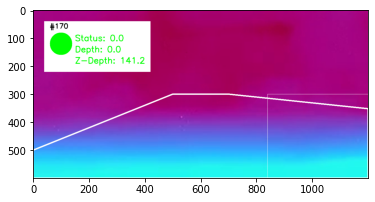

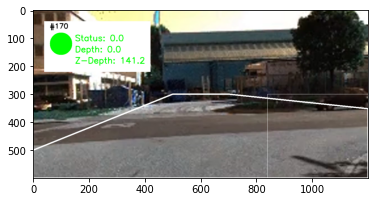

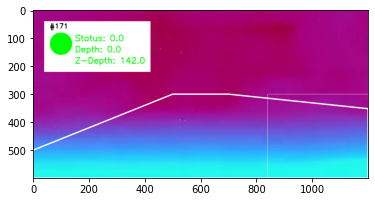

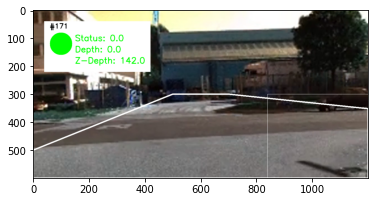

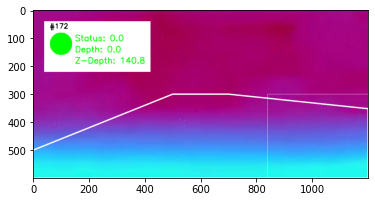

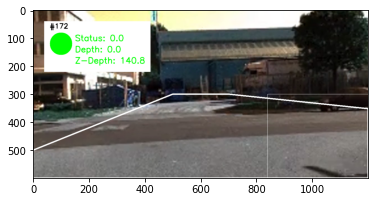

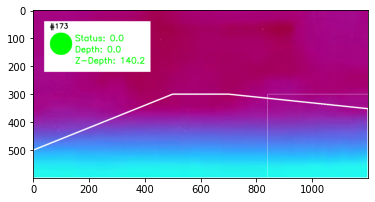

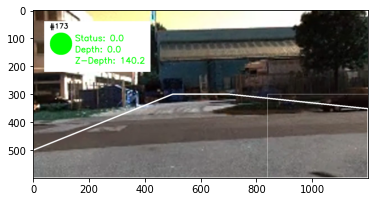

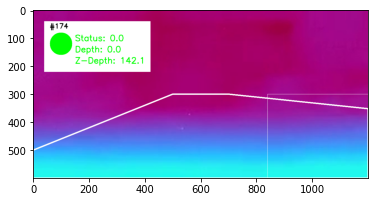

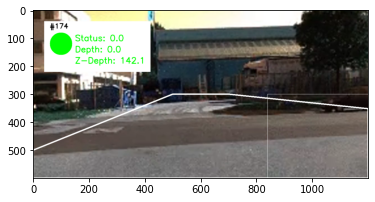

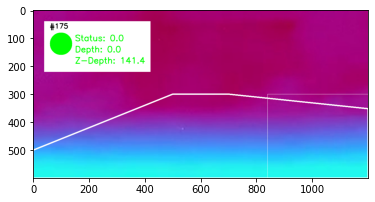

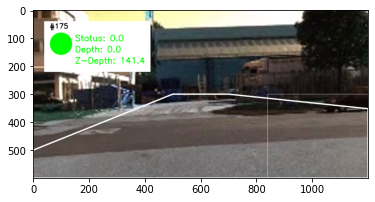

In [39]:
args["start_frame"] = 150
args["end_frame"] = 175

def inROI(x, y, w, h,contour):
	center_x = int (x+w/2)
	center_y = int (y+h/2)
	return (cv2.pointPolygonTest(contour, (center_x,center_y), False)>=0) #return 0 or 1 if inside
 
# load the COCO class labels our YOLO model was trained on
labelsPath = os.path.sep.join([args["yolo"], "coco.names"])
LABELS = open(labelsPath).read().strip().split("\n")

# initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
	dtype="uint8")

# derive the paths to the YOLO weights and model configuration
weightsPath = os.path.sep.join([args["yolo"], "yolov3.weights"])
configPath = os.path.sep.join([args["yolo"], "yolov3.cfg"])

# load our YOLO object detector trained on COCO dataset (80 classes)
# and determine only the *output* layer names that we need from YOLO
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# initialize the video stream, pointer to output video file, and
# frame dimensions
vs = cv2.VideoCapture(args["input"])
vs_depth = cv2.VideoCapture(args["input_depth"])

writer = None
writer2 = None
(W, H) = (None, None)

# try to determine the total number of frames in the video file
try:
	prop = cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() \
		else cv2.CAP_PROP_FRAME_COUNT
	total = int(vs.get(prop))
	#print("[INFO] {} total frames in video".format(total))
	if args["end_frame"]>total:
		args["end_frame"] = total
	print("[INFO] {} total frames in video".format(args["end_frame"]-args["start_frame"]))

# an error occurred while trying to determine the total
# number of frames in the video file
except:
	print("[INFO] could not determine # of frames in video")
	print("[INFO] no approx. completion time can be provided")
	total = -1

# loop over frames from the video file stream
count = 0
while True:
	# read the next frame from the file
	(grabbed, frame) = vs.read()
	(grabbed_depth, frame_depth) = vs_depth.read()
	# if the frame was not grabbed, then we have reached the end
	# of the stream
	count = count+1
	if (count < args['start_frame']):
		continue;
	elif (count > args['end_frame']):
		break;
	#if (count == 200):
	#	break
	if not grabbed:
		break
	c1 = 50
	r1 = 50
	#frame = frame[c1:c1+100,r1:r1+100]
	# if the frame dimensions are empty, grab them
	if W is None or H is None:
		(H, W) = frame.shape[:2]
	
	#Define ROI for obstacles
	cnt = np.array([ [0,H], [0,H-100], [int(W/2)-100,int(H/2)],
	                   [int(W/2)+100,int(H/2)], [W,int(H/1.7)], [W,H]], 
										         dtype=np.int32)


	# construct a blob from the input frame and then perform a forward
	# pass of the YOLO object detector, giving us our bounding boxes
	# and associated probabilities
	blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416),
		swapRB=True, crop=False)
	net.setInput(blob)
	start = time.time()
	layerOutputs = net.forward(ln)
	end = time.time()

	# initialize our lists of detected bounding boxes, confidences,
	# and class IDs, respectively
	boxes = []
	confidences = []
	classIDs = []
	depths = []
	status_code = 0
	roi_mean_max = 0
	valid_detection = False
	# loop over each of the layer outputs
	for output in layerOutputs:
		# loop over each of the detections
		for detection in output:
			# extract the class ID and confidence (i.e., probability)
			# of the current object detection
			scores = detection[5:]
			classID = np.argmax(scores)
			confidence = scores[classID]
			


			# filter out weak predictions by ensuring the detected
			# probability is greater than the minimum probability
			# if object is in list of obstacles
			if (confidence > args["confidence"] and LABELS[classID] in args["obstacles"] ):
				# scale the bounding box coordinates back relative to
				# the size of the image, keeping in mind that YOLO
				# actually returns the center (x, y)-coordinates of
				# the bounding box followed by the boxes' width and
				# height

				
				box = detection[0:4] * np.array([W, H, W, H])
				(centerX, centerY, width, height) = box.astype("int")
				height=int(height)
				width=int(width)
				# use the center (x, y)-coordinates to derive the top
				# and and left corner of the bounding box
				x = int(centerX - (width / 2))
				y = int(centerY - (height / 2))
				#ignore left side
				if (x<0.5*W or not(inROI(x,y,width,height,cnt))):
					break

				
				
				ROI = frame_depth[y:y+height, x:x+width]
				#imshow(ROI)
				#print(y,height,x,width)
				roi_mean = np.mean(ROI)
				#print(roi_mean)
				if (roi_mean>roi_mean_max):
					roi_mean_max = roi_mean
					x_max=x
					y_max=y
					height_max=height
					width_max=width
					cID_max = classID
					c_max = float(confidence)
		 
				if (roi_mean_max>0):
					valid_detection = True #

				# update our list of bounding box coordinates,
				# confidences, and class IDs
				
				#boxes.append([x, y, int(width), int(height)])
				#confidences.append(float(confidence))
				#classIDs.append(classID)

	# apply non-maxima suppression to suppress weak, overlapping
	# bounding boxes
	color_red = (255,0,0)
	color_green = (0,255,0)
	color_orange = (255, 128, 0)
	color_white = (255,255,255)
	color_black = (0,0,0)
	status_colors = [color_green,color_orange,color_red]

	#draw board
	cv2.rectangle(frame, (40, 40), (420,220), color_white, -1)
	cv2.rectangle(frame_depth, (40, 40), (420,220), color_white, -1)
	
	#draw zone
	zw1 = int(.7*W)
	zw2 = int(W)
	zh1 = int(.5*H)
	zh2 = int(H)
	cv2.rectangle(frame, (zw1, zh1), (zw2,zh2), color_white, 1)
	cv2.rectangle(frame_depth, (zw1, zh1), (zw2,zh2), color_white, 1)
	ROI = frame_depth[zh1:zh2, zw1:zw2]
	zone_depth = np.mean(ROI)

	#cv2.rectangle(frame_depth, (40, 40), (420,220), color_white, -1)

	#draw street
	cv2.drawContours(frame, [cnt], -1, (255,255,255), 3)
	cv2.drawContours(frame_depth, [cnt], -1, (255,255,255), 3)

	if (roi_mean_max>100 and valid_detection):
		status_code = 2
		boxes.append([x_max, y_max, width_max, height_max])
		confidences.append(float(c_max))
		classIDs.append(cID_max)
		depths.append(roi_mean_max)
 
	idxs = cv2.dnn.NMSBoxes(boxes, confidences, args["confidence"],
		args["threshold"])

	# print messages to board
	b_frame = "#" + str(count)
	b_text1 = "{}: {:.1f}".format("Status",status_code)
	b_text2 = "{}: {:.1f}".format("Depth",roi_mean_max)
	b_text3 = "{}: {:.1f}".format("Z-Depth",zone_depth)	
	b_color = status_colors[status_code]

	cv2.putText(frame_depth, b_frame, (60, 65),
				cv2.FONT_HERSHEY_SIMPLEX, .8, color_black, 2)
 
	cv2.putText(frame_depth, b_text1, (150, 110),
				cv2.FONT_HERSHEY_SIMPLEX, 1, b_color, 2)
	cv2.putText(frame_depth, b_text2, (150, 150),
				cv2.FONT_HERSHEY_SIMPLEX, 1, b_color, 2)
	cv2.putText(frame_depth, b_text3, (150, 190),
				cv2.FONT_HERSHEY_SIMPLEX, 1, b_color, 2)
	cv2.circle(frame_depth,(100,120), 40, b_color, -1)


	cv2.putText(frame, b_frame, (60, 65),
				cv2.FONT_HERSHEY_SIMPLEX, .8, color_black, 2) 
 
	cv2.putText(frame, b_text1, (150, 110),
				cv2.FONT_HERSHEY_SIMPLEX, 1, b_color, 2)
	cv2.putText(frame, b_text2, (150, 150),
				cv2.FONT_HERSHEY_SIMPLEX, 1, b_color, 2)
	cv2.putText(frame, b_text3, (150, 190),
				cv2.FONT_HERSHEY_SIMPLEX, 1, b_color, 2)
	cv2.circle(frame,(100,120), 40, b_color, -1)	
	# ensure at least one detection exists
	if len(idxs) > 0:
		# loop over the indexes we are keeping
		for i in idxs.flatten():
			# extract the bounding box coordinates
			(x, y) = (boxes[i][0], boxes[i][1])
			(w, h) = (boxes[i][2], boxes[i][3])


			# draw a bounding box rectangle and label on the frame
			color = [int(c) for c in COLORS[classIDs[i]]]
			cv2.rectangle(frame_depth, (x, y), (x + w, y + h), color, 2)
			text = "{}: {:.1f}".format(LABELS[classIDs[i]],
				confidences[i])
			cv2.putText(frame_depth, text, (x, y - 5),
				cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

			text2 = "{}: {:.1f}".format("Depth",
				depths[i])
			cv2.putText(frame_depth, text2, (x, y - 20),
				cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
			#cv2.line(frame_depth, (W, int(H/1.5)), ( int(W/2)+100, int(H/2)), (255, 255, 255), thickness=2)
			#cv2.line(frame_depth, (0, H-100), (int(W/2)-100, int(H/2)), (255, 255, 255), thickness=3)
			
			#on original frame
			# draw a bounding box rectangle and label on the frame
			cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
			text = "{}: {:.1f}".format(LABELS[classIDs[i]],
				confidences[i])
			cv2.putText(frame, text, (x, y - 5),
				cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

			text2 = "{}: {:.1f}".format("Depth",
				depths[i])
			cv2.putText(frame, text2, (x, y - 20),
				cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
			#cv2.line(frame_depth, (W, int(H/1.5)), ( int(W/2)+100, int(H/2)), (255, 255, 255), thickness=2)
			#cv2.line(frame_depth, (0, H-100), (int(W/2)-100, int(H/2)), (255, 255, 255), thickness=3)

			

	plt.figure()
	plt.imshow(frame_depth)
	plt.figure()
	plt.imshow(frame)
	 
	# check if the video writer is None
	if writer is None:
		# initialize our video writer
		fourcc = cv2.VideoWriter_fourcc(*"MJPG")
		writer = cv2.VideoWriter(args["output"], fourcc, 30,
			(frame.shape[1], frame.shape[0]), True)

	# check if the video writer is None
	if writer2 is None:
		# initialize our video writer
		fourcc = cv2.VideoWriter_fourcc(*"MJPG")
		writer2 = cv2.VideoWriter(args["output_depth"], fourcc, 30,
			(frame_depth.shape[1], frame_depth.shape[0]), True)

		# some information on processing single frame
		if total > 0:
			elap = (end - start)
			print("[INFO] single frame took {:.4f} seconds".format(elap))
			#print("[INFO] estimated total time to finish: {:.4f}".format(
			#	elap * total))
			print("[INFO] estimated total time to finish: {:.4f}".format(elap * (args["end_frame"]-args["start_frame"])))


	# write the output frame to disk
	writer.write(frame)
	writer2.write(frame_depth)

# release the file pointers
print("[INFO] cleaning up...")
writer.release()
writer2.release()
vs.release()